# Example for running HiggsTools to constrain the 2HDM parameter space

This example shows how HiggsTools can be used to constrain the 2HDM parameter space. ScannerS output files are used as an input 

In [ ]:
import Higgs.predictions as HP
import Higgs.bounds as HB
import Higgs.signals as HS
import numpy as np
import pandas as pd
from tqdm import tqdm

pred = HP.Predictions() # create the model predictions
bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
signals = HS.Signals('/Path/To/HSDataSet') # load HS dataset

### Set up HiggsPredictions

In [2]:
h = pred.addParticle(HP.BsmParticle("h", "neutral", "even"))
h.setMass(125.09)

H = pred.addParticle(HP.BsmParticle("H", "neutral", "even"))
H.setMass(800)

A = pred.addParticle(HP.BsmParticle("A", "neutral", "odd"))
A.setMass(800)

X = pred.addParticle(HP.BsmParticle("X", "single"))
X.setMass(800)

### Define functions for reading ScannerS output into HiggsPredictions and for running HiggsBounds + HiggsSignals

In [39]:
class DecayError(Exception): pass

cs = np.cos
ss = np.sin

# run HB and HS for one parameter point pt with couplings cpl
def run_higgstools(cpl, pt):
    set_h_properties(cpl[0], pt)
    set_H_properties(cpl[1], pt)
    set_A_properties(cpl[2], pt)
    set_X_properties(pt)
    res = bounds(pred)
    chisq = signals(pred)
    return res, chisq

# set properties of the h boson
def set_h_properties(dc, pt):
    cpls = HP.NeutralEffectiveCouplings()
    cpls.tt = dc['tt']
    cpls.bb = dc['bb']
    cpls.ZZ = dc['ZZ']
    cpls.WW = dc['WW']
    HP.effectiveCouplingInput(
        h,
        cpls,
        reference=HP.ReferenceModel.SMHiggsEW)
    w = pt['Wh']
    h.setDecayWidth('gg', pt['BRh2gg'] * w)
    h.setDecayWidth('bb', pt['BRh2bb'] * w)
    h.setDecayWidth('tautau', pt['BRh2ll'] * w)
    h.setDecayWidth('cc', pt['BRh2cc'] * w)
    h.setDecayWidth('ss', pt['BRh2ss'] * w)
    h.setDecayWidth('mumu', pt['BRh2mm'] * w)
    h.setDecayWidth('gamgam', pt['BRh2yy'] * w)
    h.setDecayWidth('Zgam', pt['BRh2Zy'] * w)
    h.setDecayWidth('WW', pt['BRh2WW'] * w)
    h.setDecayWidth('ZZ', pt['BRh2ZZ'] * w)
    if abs(h.totalWidth() - w) > 1e-3:
        raise DecayError("Missing decay channel for particle h.")

# set properties of the H boson
def set_H_properties(dc, pt):
    cpls = HP.NeutralEffectiveCouplings()
    cpls.tt = dc['tt']
    cpls.bb = dc['bb']
    cpls.ZZ = dc['ZZ']
    cpls.WW = dc['WW']
    HP.effectiveCouplingInput(
        H,
        cpls,
        reference=HP.ReferenceModel.SMHiggs)
    # H.setCxn('LHC13', 'ggH', pt['XSHgg'])
    # H.setCxn('LHC13', 'bbH', pt['XSHbb'])
    w = pt['WH']
    H.setDecayWidth('gg', pt['BRH2gg'] * w)
    H.setDecayWidth('WW', pt['BRH2WW'] * w)
    H.setDecayWidth('ZZ', pt['BRH2ZZ'] * w)
    H.setDecayWidth('gamgam', pt['BRH2yy'] * w)
    H.setDecayWidth('tt', pt['BRH2tt'] * w)
    H.setDecayWidth('bb', pt['BRH2bb'] * w)
    H.setDecayWidth('cc', pt['BRH2cc'] * w)
    H.setDecayWidth('ss', pt['BRH2ss'] * w)
    H.setDecayWidth('tautau', pt['BRH2ll'] * w)
    H.setDecayWidth('h', 'h', pt['BRH2hh'] * w)
    if abs(H.totalWidth() - w) > 1e-3:
        raise DecayError("Missing decay channel for particle H.")

# set properties of the A boson
def set_A_properties(dc, pt):
    cpls = HP.NeutralEffectiveCouplings()
    cpls.tt = 1j*dc['tt']
    cpls.bb = 1j*dc['bb']
    HP.effectiveCouplingInput(
        A,
        cpls,
        reference=HP.ReferenceModel.SMHiggs)
    # A.setCxn('LHC13', 'ggH', pt['XSAgg'])
    # A.setCxn('LHC13', 'bbH', pt['XSAbb'])
    w = pt['WA']
    A.setDecayWidth('gg', pt['BRA2gg'] * w)
    A.setDecayWidth('gamgam', pt['BRA2yy'] * w)
    A.setDecayWidth('tt', pt['BRA2tt'] * w)
    A.setDecayWidth('bb', pt['BRA2bb'] * w)
    A.setDecayWidth('cc', pt['BRA2cc'] * w)
    A.setDecayWidth('ss', pt['BRA2ss'] * w)
    A.setDecayWidth('tautau', pt['BRA2ll'] * w)
    A.setDecayWidth('Z', 'h', pt['BRA2Zh'] * w)
    if abs(A.totalWidth() - w) > 1e-3:
        raise DecayError("Missing decay channel for particle A.")

# set properties of the charged Higgs boson
def set_X_properties(pt):
    X.setCxn('LHC13', 'Hpmtb', pt['XSXtb'])
    w = pt['WX']
    X.setDecayWidth('tb', pt['BRX2tb'] * w)
    X.setDecayWidth('t', 's', pt['BRX2ts'] * w)
    X.setDecayWidth('t', 'd', pt['BRX2td'] * w)
    X.setDecayWidth('cb', pt['BRX2cb'] * w)
    X.setDecayWidth('cs', pt['BRX2cs'] * w)
    X.setDecayWidth('taunu', pt['BRX2lv'] * w)
    X.setDecayWidth('W', 'h', pt['BRX2Wh'] * w)
    if abs(X.totalWidth() - w) > 1e-3:
        raise DecayError("Missing decay channel for particle Hp.")

# read ScannerS output file
def read_scanners_output(path):
    df = pd.read_csv(path)
    dcs = []
    for i, r in df.iterrows():
        dc = {}
        dc['tb'] = r['tbeta']
        dc['al'] = r['alpha']
        dc['BRh2bb'] = r['b_Hl_bb']
        dc['BRh2ll'] = r['b_Hl_tautau']
        dc['BRh2cc'] = r['b_Hl_cc']
        dc['BRh2ss'] = r['b_Hl_ss']
        dc['BRh2mm'] = r['b_Hl_mumu']
        dc['BRh2ZZ'] = r['b_Hl_ZZ']
        dc['BRh2WW'] = r['b_Hl_WW']
        dc['BRh2gg'] = r['b_Hl_gg']
        dc['BRh2yy'] = r['b_Hl_gamgam']
        dc['BRh2Zy'] = r['b_Hl_Zgam']
        dc['BRA2gg'] = r['b_A_gg']
        dc['BRA2yy'] = r['b_A_gamgam']
        dc['BRA2tt'] = r['b_A_tt']
        dc['BRA2bb'] = r['b_A_bb']
        dc['BRA2cc'] = r['b_A_cc']
        dc['BRA2ss'] = r['b_A_ss']
        dc['BRA2ll'] = r['b_A_tautau']
        dc['BRA2Zh'] = r['b_A_ZHl']
        dc['BRH2hh'] = r['b_Hh_HlHl']
        dc['BRH2WW'] = r['b_Hh_WW']
        dc['BRH2ZZ'] = r['b_Hh_ZZ']
        dc['BRH2bb'] = r['b_Hh_bb']
        dc['BRH2cc'] = r['b_Hh_cc']
        dc['BRH2ss'] = r['b_Hh_ss']
        dc['BRH2yy'] = r['b_Hh_gamgam']
        dc['BRH2ll'] = r['b_Hh_tautau']
        dc['BRH2tt'] = r['b_Hh_tt']
        dc['BRH2gg'] = r['b_Hh_gg']
        dc['BRX2Wh'] = r['b_Hp_WHl']
        dc['BRX2lv'] = r['b_Hp_taunu']
        dc['BRX2tb'] = r['b_Hp_tb']
        dc['BRX2ts'] = r['b_Hp_ts']
        dc['BRX2td'] = r['b_Hp_td']
        dc['BRX2cb'] = r['b_Hp_cb']
        dc['BRX2cs'] = r['b_Hp_cs']
        dc['XSHgg'] = r['x_Hh_ggH']
        dc['XSHbb'] = r['x_Hh_bbH']
        dc['XSAgg'] = r['x_A_ggH']
        dc['XSAbb'] = r['x_A_bbH']
        dc['XSXtb'] = r['x_tHpm']
        dc['Wh'] = r['w_Hl']
        dc['WH'] = r['w_Hh']
        dc['WA'] = r['w_A']
        dc['WX'] = r['w_Hp']
        dcs.append(dc)
    return dcs

# calculate effective couplings
def calc_effective_couplings(al, be, yuktype):
    if yuktype == 1:
        dcs = calc_effective_cpls_type1(al, be)
    elif yuktype == 2:
        dcs = calc_effective_cpls_type2(al, be)
    elif yuktype == 3:
        dcs = calc_effective_cpls_type3(al, be)
    elif yuktype == 4:
        dcs = calc_effective_cpls_type4(al, be)
    else:
        raise RuntimeError
    return dcs

# calculate effective couplings in type 1
def calc_effective_cpls_type1(a, b):
    uu = cs(a) / ss(b)
    dd = uu
    vv = ss(b - a)
    cplh = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = ss(a) / ss(b)
    dd = uu
    vv = cs(b - a)
    cplH = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = 1 / np.tan(b)
    dd = -1 / np.tan(b)
    cplA = {
        'tt': uu,
        'bb': dd}
    return [cplh, cplH, cplA]

# calculate effective couplings in type 2
def calc_effective_cpls_type2(a, b):
    uu = cs(a) / ss(b)
    dd = -ss(a) / cs(b)
    vv = ss(b - a)
    cplh = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = ss(a) / ss(b)
    dd = cs(a) / cs(b)
    vv = cs(b - a)
    cplH = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = 1 / np.tan(b)
    dd = np.tan(b)
    cplA = {
        'tt': uu,
        'bb': dd}
    return [cplh, cplH, cplA]

# calculate effective couplings in type 3
def calc_effective_cpls_type3(a, b):
    uu = cs(a) / ss(b)
    dd = uu
    vv = ss(b - a)
    cplh = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = ss(a) / ss(b)
    dd = uu
    vv = cs(b - a)
    cplH = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = 1 / np.tan(b)
    dd = -1 / np.tan(b)
    cplA = {
        'tt': uu,
        'bb': dd}
    return [cplh, cplH, cplA]

# calculate effective couplings in type 4
def calc_effective_cpls_type4(a, b):
    uu = cs(a) / ss(b)
    dd = -ss(a) / cs(b)
    vv = ss(b - a)
    cplh = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = ss(a) / ss(b)
    dd = cs(a) / cs(b)
    vv = cs(b - a)
    cplH = {
        'tt': uu,
        'bb': dd,
        'ZZ': vv,
        'WW': vv}
    uu = 1 / np.tan(b)
    dd = np.tan(b)
    cplA = {
        'tt': uu,
        'bb': dd}
    return [cplh, cplH, cplA]

# process dataset and save output to file
def process_data(dataset, yuktype):
    data = []
    for point in tqdm(dataset):
        tb = point['tb']
        al = point['al']
        be = np.arctan(tb)
        cba = cs(be - al)
        cpl = calc_effective_couplings(al, be, yuktype)
        reshb, Chisq = run_higgstools(cpl, point)
        data.append({
            'tb': tb,
            'cba': cba,
            'chisq': Chisq,
            'hexp': reshb.selectedLimits['H'].expRatio(),
            'hobs': reshb.selectedLimits['H'].obsRatio(),
            'hcha': reshb.selectedLimits['H'].limit().citeKey(),
            'aexp': reshb.selectedLimits['A'].expRatio(),
            'aobs': reshb.selectedLimits['A'].obsRatio(),
            'acha': reshb.selectedLimits['A'].limit().citeKey(),
            'xexp': reshb.selectedLimits['X'].expRatio(),
            'xobs': reshb.selectedLimits['X'].obsRatio(),
            'xcha': reshb.selectedLimits['X'].limit().citeKey()})
    df = pd.DataFrame(data)
    df.to_csv(f'result_type{yuktype}.csv')

### Run HiggsTools on ScannerS datasets

In [4]:
type1_dataset = read_scanners_output('../example_data/2HDMtype1.csv')
type2_dataset = read_scanners_output('../example_data/2HDMtype2.csv')
type3_dataset = read_scanners_output('../example_data/2HDMtype3.csv')
type4_dataset = read_scanners_output('../example_data/2HDMtype4.csv')

In [ ]:
process_data(type1_dataset, 1)
process_data(type2_dataset, 2)
process_data(type3_dataset, 3)
process_data(type4_dataset, 4)

### Plotting

In [46]:
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

In [47]:
# main plotting function
def plot_2HDM_bounds(yuktype):
    df  = pd.read_csv(f'result_type{yuktype}.csv')
    df2 = pd.read_csv(f'../example_data/2HDMtype{yuktype}.csv')

    x = np.array(df['chisq'].tolist())
    m = np.min(x)
    x = x - m
    y = [z if z < 6.001 else 6.001 for z in x]
    df['col'] = y

    x1 = []
    x2 = []
    for i, r in df.iterrows():
        if (r['hobs'] < 1) and (r['aobs'] < 1) and (r['xobs'] < 1):
            x1.append(0)
        else:
            x1.append(1)
    for i, r in df2.iterrows():
        if (r['hb_Hh_obsratio'] < 1) and (r['hb_A_obsratio'] < 1) \
            and (r['hb_Hp_obsratio'] < 1):
            x2.append(0)
        else:
            x2.append(0.1)
    df['col2'] = x1
    df['col3'] = x2

    xscale = np.max(df['cba']) - np.min(df['cba'])
    yscale = np.max(df['tb']) - np.min(df['tb'])
    scale = np.array([xscale, yscale])

    mat = np.array([
        df['cba'].to_numpy(),
        df['tb'].to_numpy(),
        df['col'].to_numpy()]).T
    x = np.linspace(-0.4, 0.4, 1000)
    y = np.linspace(1, 10, 1000)
    X, Y = np.meshgrid(x, y)
    Z = interpolate.griddata(
        mat[:,0:2] / scale,
        mat[:,2],
        (X / xscale, Y / yscale),
        method='nearest')

    fig, ax = plt.subplots(
        figsize=(3.4, 3.4),
        constrained_layout=True)

    sc = ax.scatter(
        df['cba'],
        df['tb'],
        c=df['col'],
        s=0.4,
        cmap='GnBu_r',
        rasterized=True)

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(1, 10)

    clb = fig.colorbar(
        sc,
        ax=ax,
        label=r"$\Delta\chi^2$",
        ticks=np.arange(0, 6.1, 1),
        pad=0,
        fraction=0.1,
        location='top',
        aspect=40
    )
    clb.ax.minorticks_on()

    ax.contour(
        X,
        Y,
        Z,
        levels=[2.3, 5.99],
        colors="black",
        linestyles=["-", "--"],
    )

    bfp = np.unravel_index(
        np.argmin(Z), Z.shape)
    ax.plot(
        x[bfp[1]], y[bfp[0]],
        marker="*", ls="none", c="r")

    sc2 = ax.scatter(
        df['cba'],
        df['tb'],
        c='lightgray',
        s=df['col2'],
        alpha=1.0,
        rasterized=True)

    percent = "\%" if plt.rcParams["text.usetex"] else "%"
    hsLegend = ax.legend(
        handles=[
            Line2D([0], [0], color="k", ls="-", label=f"HS 68{percent} CL"),
            Line2D([0], [0], color="k", ls="--", label=f"HS 95{percent} CL"),
            Line2D([0], [0], color="k", ls="none", marker="*", c="r", label="HS BFP"),
        ],
        loc="upper right",
        frameon=False,
    )
    ax.add_artist(hsLegend)

    majorLocator = MultipleLocator(1)
    minorLocator = MultipleLocator(0.1)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.tick_params(
        axis="y",
        direction="in",
        which="both",
        right=True)

    majorLocator = MultipleLocator(0.2)
    minorLocator = MultipleLocator(0.02)
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(
        axis="x",
        direction="in",
        which="both",
        top=True)

    ax.set_xlabel(r'$\cos ( \beta - \alpha )$')
    ax.set_ylabel(r'$\tan \beta$')

    ax.text(
        0.97,
        0.03,
        f'2HDM Type {yuktype}',
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes,
        )

    plt.savefig(f'results_type{yuktype}.pdf')

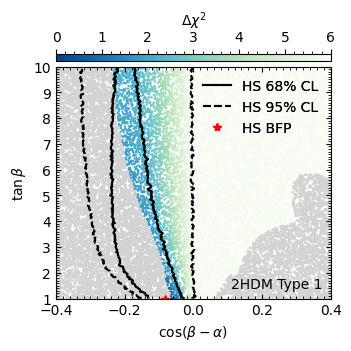

In [48]:
plot_2HDM_bounds(1)

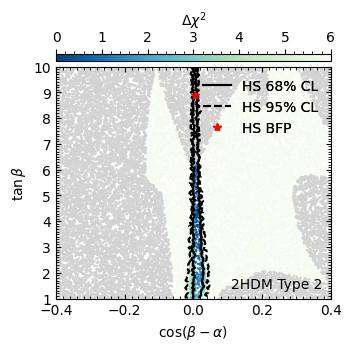

In [49]:
plot_2HDM_bounds(2)

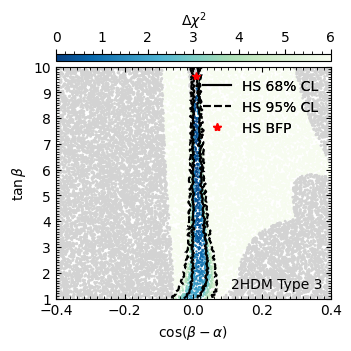

In [50]:
plot_2HDM_bounds(3)

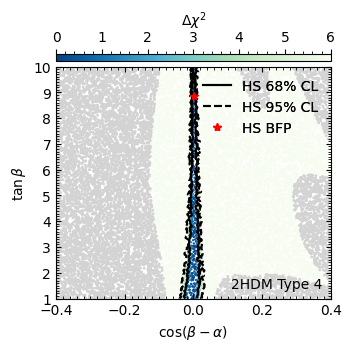

In [51]:
plot_2HDM_bounds(4)